In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28

In [2]:
!pip install pyLDAvis 
!pip install pyLDAvis.gensim

     |████████████████████████████████| 1.7MB 6.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3MB 285kB/s 
     |████████████████████████████████| 9.9MB 22.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=f9a5183ab5c6cd0480d06ae90dfcc51d7fb3a810b081b60bfdfb7d2036e35c79
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim


In [3]:

import pickle
import gensim
import pyLDAvis
#import pyLDAvis.gensim
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from keras.utils import to_categorical
import re
import warnings
from pprint import pprint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
port_data = pd.read_csv('/content/drive/MyDrive/Research Project/fdash_data_nonewlines.csv')
port_data2 = pd.read_csv('/content/drive/MyDrive/Research Project/Labeled OCR Data/labeledv5.csv')
#port_data.head()
df = pd.DataFrame(data=port_data)
labeled_data=pd.DataFrame(data=port_data2)
#df1 = df1.set_index('PolicyNo')
#df.head(10)

def clean_ocr(row):
  #cleaning out \n from ocr text and punctuation and lowercasing
  n_pattern = "\\n"
  punc = "[,\.!?@:}{}]"
  fix_string = re.sub(n_pattern," ",str(row.ocr_text))
  fix_string = re.sub(punc," ",fix_string)
  return fix_string.lower()

#lowercasing and removing punctuation
df['ocr_text']=df.apply(clean_ocr,axis=1)

# Remove punctuation
#df['ocr_text_processed'] = \
#df['ocr_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Print out the first rows of papers
labeled_data.head()
labeled_data['Hand Label'].describe()
clean_label = labeled_data
#removing non labeled data
#clean_label = labeled_data[labeled_data['Hand Label'].apply(lambda x: x.isnumeric())]
#clean_label['Hand Label'].describe()

<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence \.
<input>:12: DeprecationWarning: invalid escape sequence 

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'state', 'governor', 'therefore', 'whereas', 'shall', 'must', 'sign', 'document', 'order', 'executive', 'pursuant', 'issue', 'effective', 'follow','nsection','paragraph'])  # can find more stop words that are specific to Executive orders later
nlp = spacy.load('en', disable=['parser', 'ner'])

def strip_newline(series):
    return [str(review).replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    out = [[word for word in simple_preprocess(str(doc))
            if word not in stop_words]
            for doc in texts]
    return out

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def get_corpus(df):
    df['ocr_text'] = strip_newline(df.ocr_text)
    words = list(sent_to_words(df.ocr_text))
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram) 
    id2word.filter_extremes(no_below=10, no_above=0.35) #get rid of extreme frequency words
    #removing governor names
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    
    return corpus, id2word, bigram



train_corpus, train_id2word, bigram_train = get_corpus(df)
train_corpus_clean, train_id2word_clean, bigram_train_clean = get_corpus(clean_label)
 

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [7]:
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num=35 #number of hidden topics for LDA
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train = gensim.models.ldamodel.LdaModel(
                           corpus=train_corpus,
                           num_topics=num,
                           id2word=train_id2word,
                           chunksize=100,
                           passes=10,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train.save('lda_train_35_v2.model')

In [8]:
train_vecs = []
for i in range(len(clean_label)):
    top_topics = lda_train.get_document_topics(train_corpus_clean[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(num)]
    #topic_vec.extend([clean_label.iloc[i].real_counts]) # counts of reviews for restaurant
    #topic_vec.extend([len(clean_label.iloc[i].ocr_text)]) # length of ocr text
    train_vecs.append(topic_vec)



y = np.array(clean_label['Hand Label'])  #num,1

from imblearn.over_sampling import SMOTE, RandomOverSampler
oversample = RandomOverSampler(random_state=42)
over_train_vecs, over_y = oversample.fit_resample(train_vecs, y)

X = np.array(over_train_vecs).reshape(-1,1,num)  #1115 by num

from sklearn.utils import shuffle
train_labels = to_categorical(np.array(over_y))
train_labels = train_labels.reshape(-1,1,29)

#shuffle hand labelled data
train_labels, X = shuffle(train_labels, X)

X_train, X_test, Y_train, Y_test = train_test_split(X, train_labels, test_size=0.2, random_state=0)




/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [9]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout


our_model = Sequential()
our_model.add(InputLayer(input_shape=[1,35]))
our_model.add(Dense(64,activation='tanh'))
our_model.add(Dense(64,activation='tanh'))
our_model.add(Dropout(0.1))
our_model.add(Dense(64,activation='tanh'))
our_model.add(Dense(29,activation='softmax'))
our_model.compile(optimizer='adam', metrics=['acc',f1],loss=f1_loss)
history = our_model.fit(X_train, Y_train, epochs=25, batch_size=5)





Epoch 1/25
1585/1585 [==============================] - 5s 2ms/step - loss: 0.9818 - acc: 0.1188 - f1: 0.0083
Epoch 2/25
1585/1585 [==============================] - 3s 2ms/step - loss: 0.9502 - acc: 0.3310 - f1: 0.0439
Epoch 3/25
1585/1585 [==============================] - 3s 2ms/step - loss: 0.9406 - acc: 0.3938 - f1: 0.0559
Epoch 4/25
1585/1585 [==============================] - 3s 2ms/step - loss: 0.9323 - acc: 0.4528 - f1: 0.0666
Epoch 5/25
1585/1585 [==============================] - 3s 2ms/step - loss: 0.9292 - acc: 0.4670 - f1: 0.0715
Epoch 6/25
1585/1585 [==============================] - 3s 2ms/step - loss: 0.9269 - acc: 0.4779 - f1: 0.0737
Epoch 7/25
1585/1585 [==============================] - 3s 2ms/step - loss: 0.9237 - acc: 0.4966 - f1: 0.0772
Epoch 8/25
1585/1585 [==============================] - 3s 2ms/step - loss: 0.9224 - acc: 0.5060 - f1: 0.0786
Epoch 9/25
1585/1585 [==============================] - 3s 2ms/step - loss: 0.9183 - acc: 0.5261 - f1: 0.0826
Epoch 10/2

In [10]:
#attempting to predict a topic based on LDA analysis (LDA analysis is the X input here)
#first entry of X is corresponding to row 255, should return 26 as the highest value
#labelled as 3 but returns 26
#clean_label.iloc[0]['ocr_text']


our_model.summary()
our_y_test_pred = our_model.predict(x=X_test,batch_size=None, verbose=0, steps=None)
#len(our_y_test_pred)
#len(Y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 64)             2304      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 64)             4160      
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 64)             4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 29)             1885      
Total params: 12,509
Trainable params: 12,509
Non-trainable params: 0
_________________________________________________________________


In [44]:
import collections
from collections import Counter
import numpy as np
def my_acc(y_true_vec,y_pred_vec):
  #if top two predictions match the true value, count it as correct
  correct = 0
  for i in range(len(y_true_vec)):
    y_true = np.array(y_true_vec[i][0])
    y_pred = np.array(y_pred_vec[i][0])
    y_pred_ind = y_pred.argsort()[-10:]
    y_true_ind = y_true.argsort()[-1:]
    #print(y_true_ind)
    #print(y_pred_ind)
    if set(y_true_ind) & set(y_pred_ind):
      correct += 1
  #print(correct)
  return correct/len(y_true_vec)*100
print(my_acc(Y_test,our_y_test_pred))
def my_acc2(y_true_vec,y_pred_vec):
  #if top two predictions match the true value, count it as correct
  correct = Counter()
  total = Counter()
  for i in range(len(y_true_vec)):
    y_true = np.array(y_true_vec[i][0])
    y_pred = np.array(y_pred_vec[i][0])
    y_pred_ind = y_pred.argsort()[-10:]
    y_true_ind = y_true.argsort()[-1:]
    #print(y_true_ind)
    #print(y_pred_ind)
    total[y_true_ind[0]] += 1
    if set(y_true_ind) & set(y_pred_ind):
      correct[y_true_ind[0]] += 1
  for label in total.keys():
    #print(label)
    print(f'Class: {label}')
    num = correct[label]
    den = total[label]
    acc = num/den
    print(f'Accuracy: {acc}\n')
    print(f'Accuracy: {num}"\"{den}\n')
  #print(f'Total Accuracy: {num}"\"{den}\n')
  return 
x = {'Economics': '1','Civil Rights, Minority Issues, and Civil Liberties': '2' ,'Health, Drugs, Drug Abuse/Misuse': '3','Agriculture': '4','Labor, Employment, and Immigration':'5', 
     'Education': '6', 'Environment': '7','Energy': '8','Transportation': '10','Insurance': '11','Law, Crime, and Family Issues': '12','Social Welfare': '13','Community Development and Housing Issues': '14', 'Industry, Business, Banking, Finance, and Domestic Commerce': '15',
     'Defense/National Guard': '16',
     'Space, Science, Technology and Communications': '17',
     'Foreign Trade': '18', 
     'International Affairs and Foreign Aid': '19',
     'Government Operations/ Elections Operations/Government employee benefits': '20',
     'Public Lands and Water Management/Wildlife, Parks': '21',
     'State Budget/ Taxation': '22', 
     'Local Government Control /Issues ': '23', 
     'Non-political': '24',
     'Licenses (e.g. liquor licensing, hunting licenses, drivers licenses)': '25',
     'Public safety and emergency management': '26', 
     'Celebrated Events': '27',
     'Religion/Prayer': '28' }
rev_x = {v:k for k,v in x.items()}
def get_bigram(df):
    """
    For the test data we only need the bigram data built on 2017 reviews,
    as we'll use the 2016 id2word mappings. This is a requirement due to 
    the shapes Gensim functions expect in the test-vector transformation below.
    With both these in hand, we can make the test corpus.
    """
    df['ocr_text'] = strip_newline(df.ocr_text)
    words = list(sent_to_words(df.ocr_text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
#     lemma = lemmatization(bigram)
    return bigram

def primsec(y_pred):
     y_pred = np.array(y_pred[0][0])
     #print(y_pred)
     y_pred_ind = y_pred.argsort()[-2:]
     #print(y_pred_ind)
     #print(y_pred_ind)
     y_pred_issues = [rev_x[str(item)]  for item in y_pred_ind]
     return y_pred_issues

def text_to_prediction(text):
  #feed a string of text, output a primary and secondary prediction
  df_samp = pd.DataFrame.from_dict({'ocr_text':[text]})
  samp_bigram = get_bigram(df_samp)
  #print(samp_bigram)
  samp_corpus = [train_id2word.doc2bow(text) for text in samp_bigram]
  #print(samp_corpus)
  samp_topics = lda_train.get_document_topics(samp_corpus[0], minimum_probability=0.0)
  #print(samp_topics)
  samp_topic_vec = [samp_topics[i][1] for i in range(num)]
  #print(samp_topic_vec)
  X = np.array(samp_topic_vec).reshape(-1,1,num)  #reformatting for NN prediction
  samp_pred = our_model.predict(x=X,batch_size=None, verbose=0, steps=None)
  #print(samp_pred)
  return primsec(samp_pred) 


70.58526740665994


In [12]:
text = clean_label.iloc[[11]]['ocr_text']
text_to_prediction(text)

['Insurance', 'State Budget/ Taxation']

In [17]:
my_acc2(Y_test,our_y_test_pred)

Class: 9
Accuracy: 0.44594594594594594

Accuracy: 33""74

Class: 13
Accuracy: 0.35

Accuracy: 28""80

Class: 5
Accuracy: 0.4375

Accuracy: 35""80

Class: 28
Accuracy: 1.0

Accuracy: 87""87

Class: 15
Accuracy: 0.24705882352941178

Accuracy: 21""85

Class: 6
Accuracy: 0.5909090909090909

Accuracy: 52""88

Class: 7
Accuracy: 0.5076923076923077

Accuracy: 33""65

Class: 24
Accuracy: 1.0

Accuracy: 71""71

Class: 21
Accuracy: 0.40963855421686746

Accuracy: 34""83

Class: 12
Accuracy: 0.2125

Accuracy: 17""80

Class: 23
Accuracy: 0.3333333333333333

Accuracy: 21""63

Class: 8
Accuracy: 0.55

Accuracy: 44""80

Class: 17
Accuracy: 0.7142857142857143

Accuracy: 50""70

Class: 14
Accuracy: 0.4823529411764706

Accuracy: 41""85

Class: 25
Accuracy: 0.5454545454545454

Accuracy: 42""77

Class: 10
Accuracy: 0.3

Accuracy: 21""70

Class: 4
Accuracy: 0.7746478873239436

Accuracy: 55""71

Class: 26
Accuracy: 0.37349397590361444

Accuracy: 31""83

Class: 2
Accuracy: 0.5285714285714286

Accuracy: 37""70

In [37]:
#mask = clean_label['Hand Label']==9
x1 = clean_label.loc[clean_label['Hand Label']==9]
from sklearn.metrics import confusion_matrix

pred_cm= np.reshape(our_y_test_pred, (our_y_test_pred.shape[0],  29))
pred_cm = pred_cm.argmax(axis=1)
pred_cm = pred_cm
test_cm = np.reshape(Y_test, (Y_test.shape[0],  29))
test_cm = test_cm.argmax(axis=1)
test_cm = test_cm 
cm = confusion_matrix(test_cm,pred_cm)


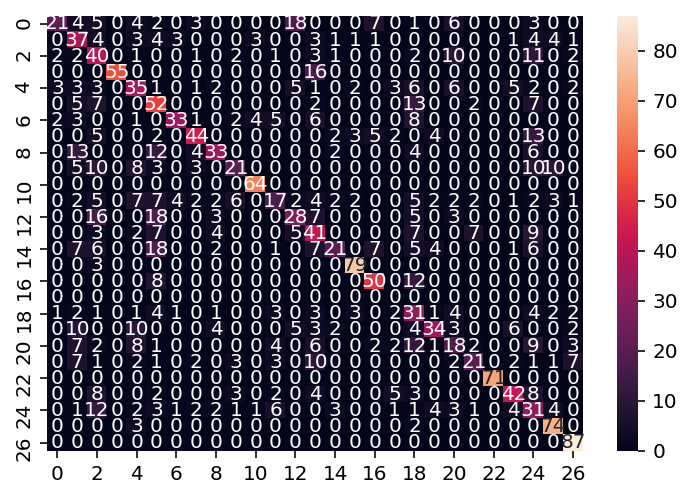

In [38]:
import seaborn as sns
sns.heatmap(cm, annot=True)